This notebook run a 3D convnet for CT images agregated as volumetric data.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential

import os
import math
import zipfile
import numpy as np
import pandas as pd
from scipy import ndimage
from pathlib import Path
import cv2

# data generator for volume

In [2]:
class VolumeDataGenerator(keras.utils.Sequence):
    
    def __init__(self, list_IDs, labels, batch_size=10, dim=(512,512,64), n_channels=1, n_classes=3, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
        
    def __data_generation(self, list_IDs_temp, labels_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, (ID, label) in enumerate(zip(list_IDs_temp, labels_temp)):
            # Store sample
            X[i,...,0] = process_scan(ID)
            # Store class
            y[i] = label

        return X, y    
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs and labels
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        labels_temp = [self.labels[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp, labels_temp)

        return X, y

# helper functions

In [3]:
#example from: https://keras.io/examples/vision/3D_image_classification/
def read_scan_path(filepath):
    """Read files and load volume"""
    # Read files
    files = sorted(list(Path(filepath).glob('**/*')))
    imgs = []
    print("### {} \nTotal of {} images.\n".format(filepath, len(files)))
    for i in files:
        img = cv2.imread(str(i), cv2.IMREAD_GRAYSCALE)
        #img = load_img(i, color_mode='grayscale')
        #x = img_to_array(np.squeeze(img))
        #img = remove_exterior(img)
        if hasattr(img, 'close'):
            img.close()
        imgs.append(img)
    
    scan = np.squeeze(np.stack(imgs, axis=2))
    return scan

def rotate(volume):
    import random
    # define some rotation angles
    angles = [-20, -10, -5, 5, 10, 20]
    # pick angles at random
    angle = random.choice(angles)
    # rotate volume
    volume = ndimage.rotate(volume, angle, reshape=False, mode='reflect')
    volume[volume < 0] = 0
    volume[volume > 1] = 1
    return volume

def normalize(volume):
    """Normalize the volume"""
    min = -1450
    max = 50
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 512
    desired_height = 512
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
#     img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def remove_exterior(image):
    """Separate lung from background and paint background with mean color"""
    filt_image = cv2.GaussianBlur(image, (5, 5), 0)
    thresh = cv2.threshold(filt_image[filt_image > 0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[0]
    bin_image = np.uint8(filt_image > thresh)
    # Find body contour
    img, contours, hierarchy = cv2.findContours(bin_image.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(cnt) for cnt in contours]
    body_idx = np.argmax(areas)
    body_cont = contours[body_idx].squeeze()
    # Exclude external regions by replacing with bg mean
    body_mask = np.zeros(image.shape, dtype=np.uint8)
    cv2.drawContours(body_mask, [body_cont], 0, 1, -1)
    body_mask = body_mask.astype(bool)
    bg_mask = (~body_mask) & (image > 0)
    # exclude bright regions from mean
    bg_dark = bg_mask & ~bin_image 
    bg_mean = np.mean(image[bg_dark])
    image[bg_mask] = bg_mean
    
    return image

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_scan_path(path)
    # Normalize
    volume = volume * (1.0/255)
    volume = volume.astype("float32")
    #volume = normalize(volume)
    volume = resize_volume(volume)
    return volume

# visualization

In [4]:
def scan_stack(volume, rows=8, cols=8, start_with=0, show_every=1):
    import matplotlib.pyplot as plt
    from itertools import product

    fig, ax = plt.subplots(rows, cols, figsize=[24, 24])

    n = len(volume)
    prod = list(product(range(rows), range(cols)))
    prod = prod[:n]

    for i, (r, c) in enumerate(prod):
        ind = start_with + i*show_every
        ax[r, c].set_title('slice %d' % ind)
        ax[r, c].imshow(volume[:,:,ind], cmap='gray')
        ax[r, c].axis('off')
    #plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

# model definition

In [5]:
def get_model(width=512, height=512, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=3, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
tf.test.gpu_device_name()


# Parameters
params = {'dim': (512,512,64),
          'batch_size': 2,
          'n_classes': 3,
          'n_channels': 1,
          'shuffle': True}

# Datasets
df = pd.read_feather('predictions_all_info.feather')
df_cut = df[df['model'] == '/misc/users/tiagonb/covid-net/models/COVID-Net_CT-1_S']
exams = df_cut[['new_split_class','dataset', 'label']]
exams = exams.drop_duplicates()
# Convert to categorical var
exams['label'] = exams['label'].astype('category')
exams['label_cat'] = exams['label'].cat.codes
# Split train, val and test
exams_train = exams[exams['new_split_class'] == 'train']
exams_val = exams[exams['new_split_class'] == 'val']
exams_test = exams[exams['new_split_class'] == 'test']

# Generators
training_generator = VolumeDataGenerator(exams_train['dataset'].values.tolist(), 
                                         exams_train['label_cat'].values.tolist(), **params)
validation_generator = VolumeDataGenerator(exams_val['dataset'].values.tolist(), 
                                           exams_val['label_cat'].values.tolist(), **params)

n_samples_train = len(exams_train.index)
n_samples_validation = len(exams_val.index)
steps_per_epoch_train = int(math.ceil(1. * n_samples_train / params['batch_size']))
steps_per_epoch_validation = int(math.ceil(1. * n_samples_validation / params['batch_size']))

# Build model.
model = get_model(width=512, height=512, depth=64)
model.summary()

# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Train model on dataset
model.fit_generator(generator=training_generator,
                    steps_per_epoch=steps_per_epoch_train,
                    validation_data=validation_generator,
                    validation_steps=steps_per_epoch_validation,
                    epochs=10,
                    use_multiprocessing=True,
                    shuffle=True,
                    verbose=2)

# scratch 

In [6]:
fpath = '/misc/users/tiagonb/covid-net/dataset/CP/1129/3347'

In [ ]:
sss = '/misc/users/tiagonb/covid-net/dataset/CP/1129/3347/0001.png'
img2 = load_img(sss, color_mode='grayscale')
img = cv2.imread(sss, cv2.IMREAD_GRAYSCALE)
img2 = img_to_array(img2)
img = remove_exterior(img2)
# print("tuple extreme: ", img.getextrema())
img = img_to_array(img)
print("min: ", img.min())
print("max: ", img.max())
plt.imshow(img, cmap="gray")

In [7]:
scan = process_scan(fpath)

### /misc/users/tiagonb/covid-net/dataset/CP/1129/3347 
Total of 158 images.



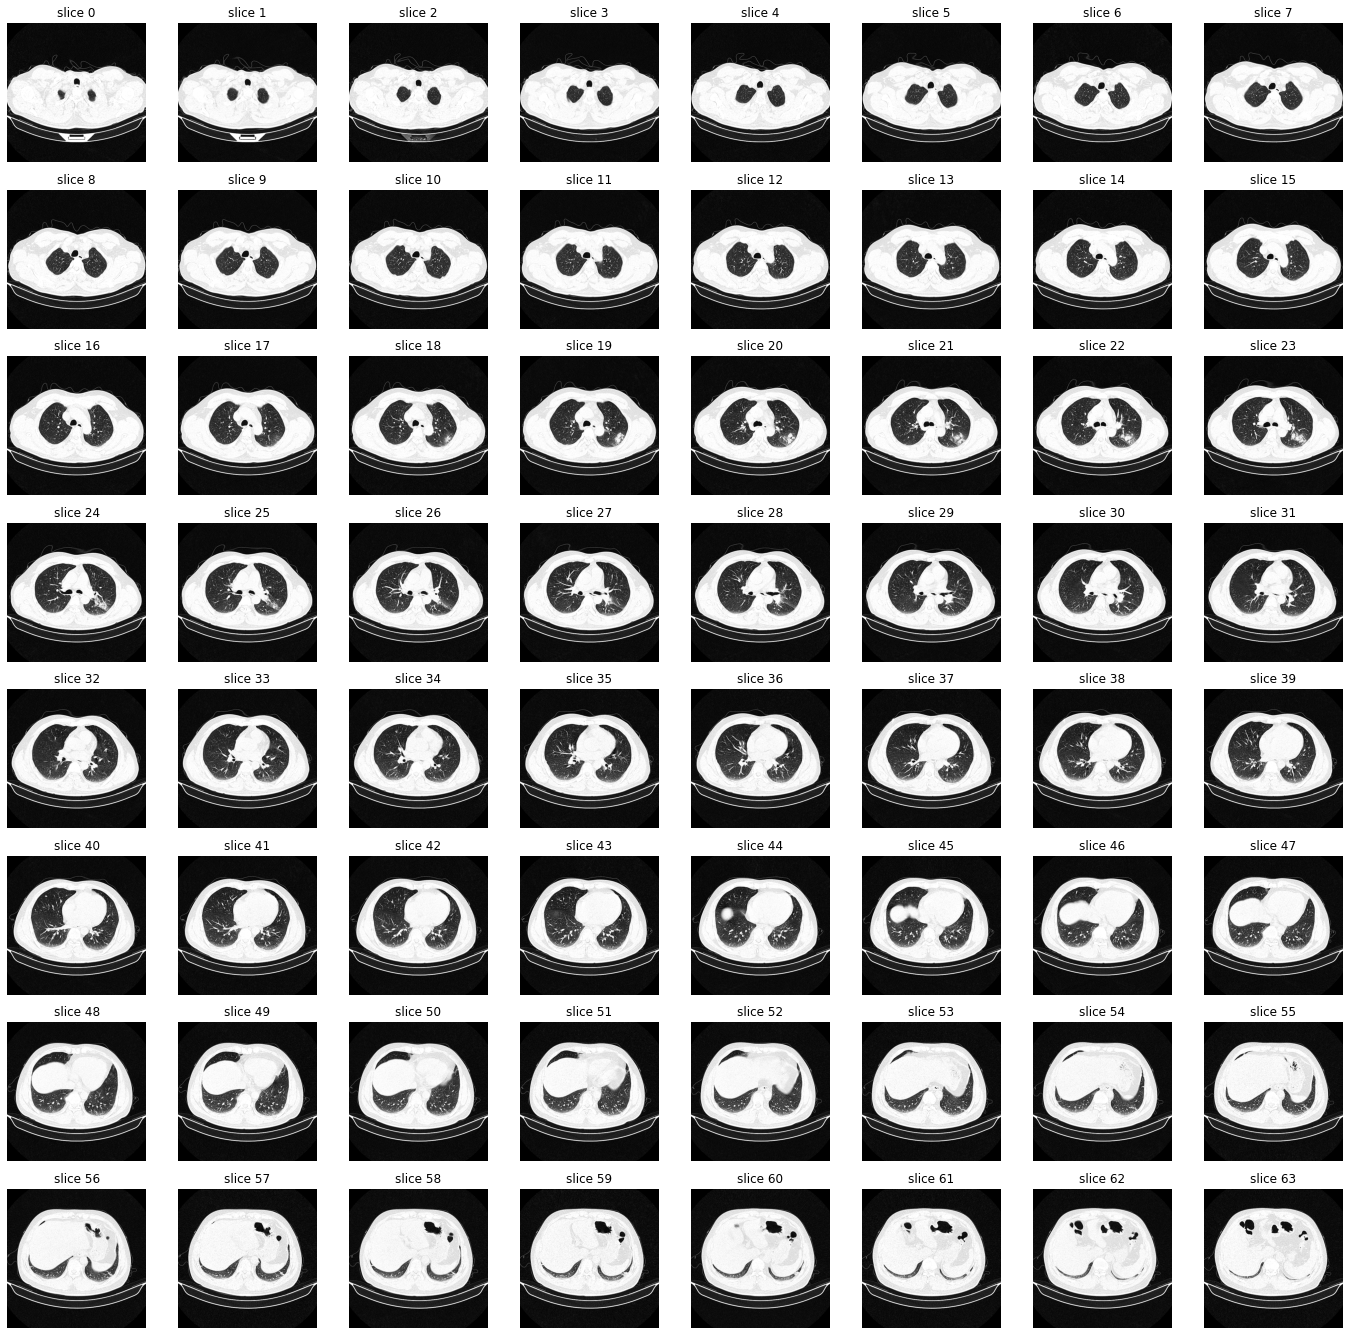

In [8]:
scan.shape
scan[...,0].dtype
scan_stack(scan)

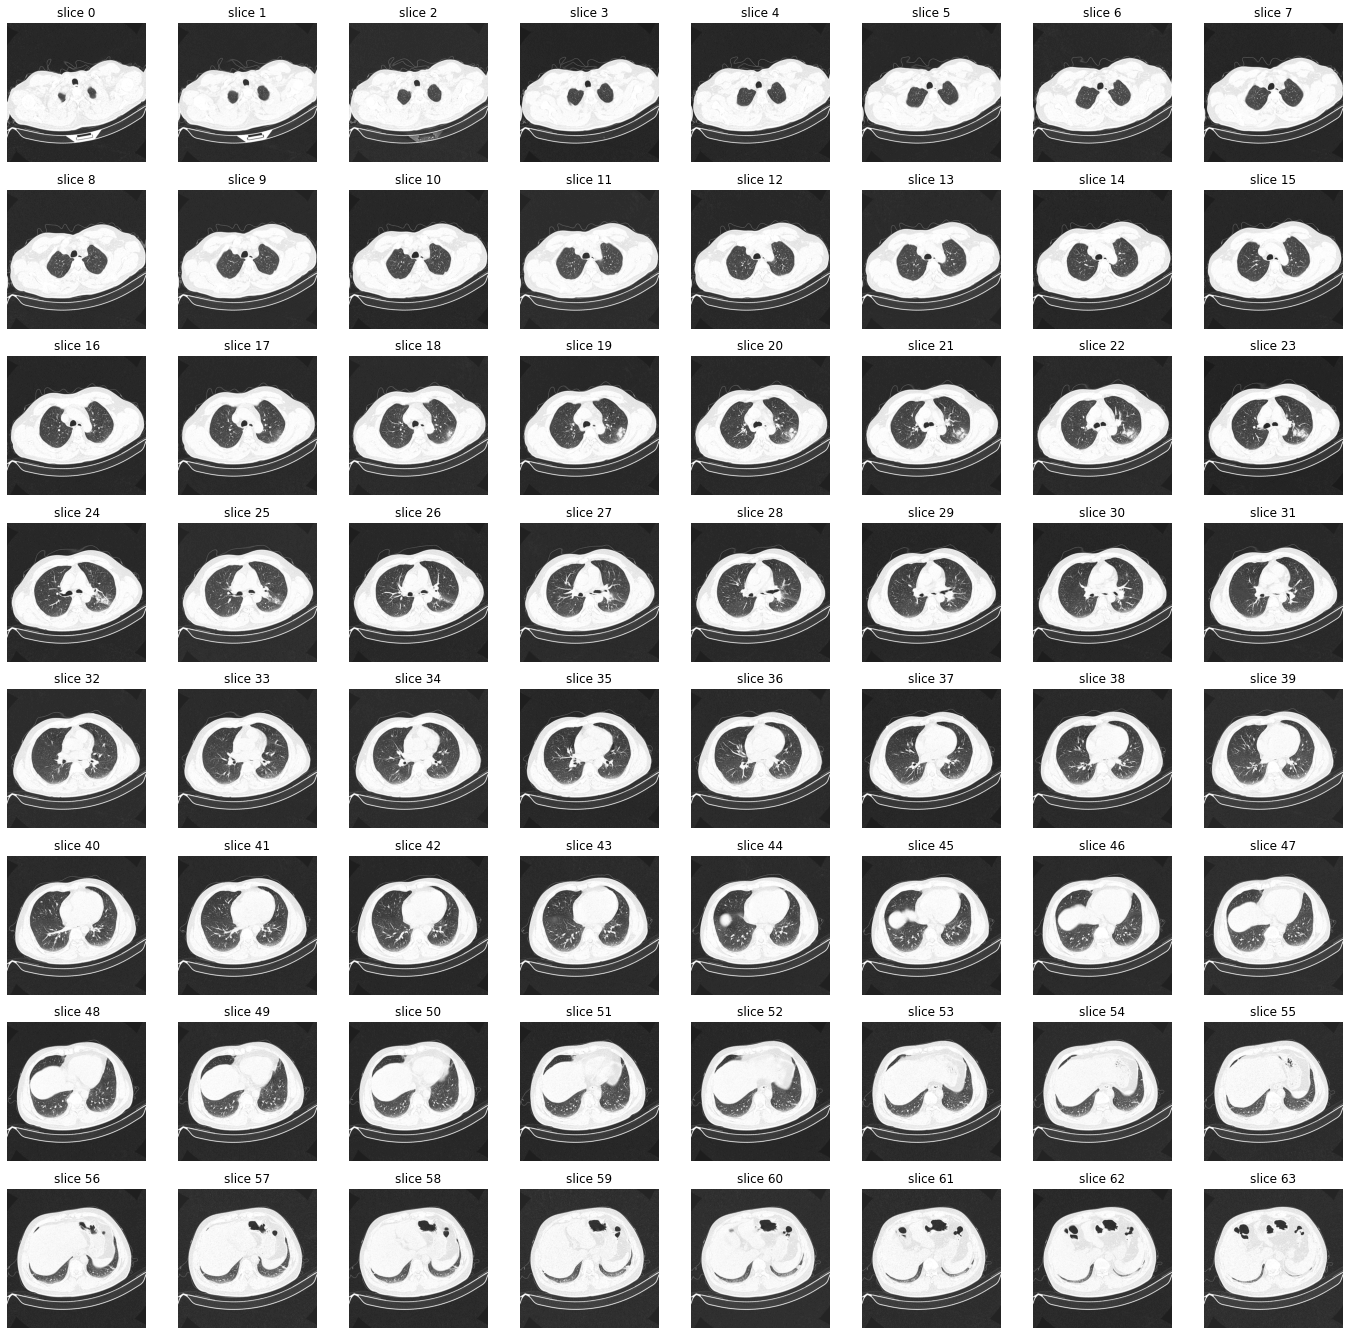

In [9]:
scan = rotate(scan)
scan_stack(scan)

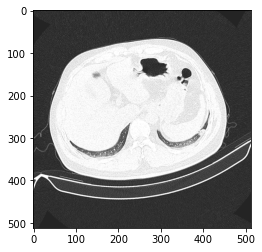

In [10]:
import matplotlib.pyplot as plt

plt.imshow(np.squeeze(scan[:,:,60]), cmap="gray")